In [85]:
import sys
import argparse
import operator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp

In [2]:
#Function to parse .ms file data into nested list of positions and genotypes
#Function takes as input open reading file object and no. of samples
def get_nested_data_list(f_ms, samples, chr_len):
    l_Pos = [] #list of positions of SNPs
    l_Genos = [] #list of alleles
    d_tmp = {} #dict to store individual allele info for each individual (values) at each site (keys)

    #positions on line 2
    pos_lines = [2]
    for position, line in enumerate(f_ms):
        if position in pos_lines:
            #store positions in list
            pos_list  = line.split()
    #Set file pointer to start of file
    f_ms.seek(0)

    i = 0
    #Loop through positions, storing in list
    for pos in pos_list[1:]:
        #Append position to l_Pos (after converting to float)
        x = int(np.round(float(pos)*chr_len,0))
        l_Pos.append(int(x))
        #Add dictionary key for each position, with empty value
        d_tmp[str(i)] = ""
        i += 1  

    #genotypes on line 3 onwards (use samples argument to determine length of file)
    g_lines = [x for x in range(3, samples + 4)]
    #Loop through lines (ie individuals)
    for position, line in enumerate(f_ms):
        if position in g_lines:
            #Remove newline character
            line1 = line.strip('\n')
            i = 0
            #For each individual, loop through each site, appending allele information for that individual to 
            #the site number in dict
            while i < len(line1):
                d_tmp[str(i)] = d_tmp[str(i)] + line1[i]
                i = i + 1

    f_ms.seek(0)

    #Create nested list of positions and genotypes
    l_data = [[j, d_tmp[str(i)]] for i,j in enumerate(l_Pos)]
    
    #Sum genotype information to get DACs
    for i,j in enumerate(l_data):
        l_data[i].append(sum([int(x) for x in l_data[i][1]]))
    
    #Convert dictionary to dataframe, removing genotype column
    df = pd.DataFrame(l_data)[[0,2]]
    #Rename columns
    df.columns = ['position', 'DAC']
    return(df)


In [3]:
#Function to extract sfs from dictionary of allele frequencies
def get_sfs(l_af, samples):
    d_sfs = {}
    s_seg = 0 #total number of truly segregating sites
    s_not_anc = 0 #required to know the d0_0 class
    #Loop through list of allele frequency categories
    for x in l_af:
        try:
            #if the category already exists, incrememnt by one
            d_sfs[x] = d_sfs[x] + 1
        except:
            #otherwise create the category
            d_sfs[x] = 1
        #add to count of segregating sites if not fixed or lost
        if int(x) > 0 and int(x) < int(samples):
            s_seg += 1
        if int(x) > 0:
            s_not_anc += 1
    return(d_sfs, s_seg, s_not_anc)

In [4]:
#Function to combine dictionaries
def combine_dicts(a, b, op=operator.add):
    return {**a, **b, **{k: op(a[k], b[k]) for k in a.keys() & b}}

In [103]:
#####Function to get discreet DFE from gamma#####
def get_DFE_proportions(shape, scale, categories):
    res = []
    num = np.random.gamma(shape = shape, scale = scale, size = 1000000)
    #Effectively neutral
    res.append(len(num[(num > categories[0]) & (num <= categories[1])])/1000000)
    #Weakly deleterious
    res.append(len(num[(num > categories[1]) & (num <= categories[2])])/1000000)
    #Moderately deleterious
    res.append(len(num[(num > categories[2]) & (num <= categories[3])])/1000000)
    #Strongly deleterious
    res.append(len(num[(num > categories[3]) & (num <= categories[4])])/1000000)
    return(res)

In [6]:
#Chromosome structure EDIT THESE!!!
totalGenes = 127
intergenicLength = 3811
exonLength = 588
exonsPerGene = 4
intronLength = 563
intronsPerGene = 3

exons = []
introns = []
intergenic = []
divergence = []

#Calculate length of gene
geneLength = (exonLength * exonsPerGene) + (intronLength * intronsPerGene)

#Loop through total number of genes to calculate coordinates for each chromosomal element type
for gene in range(0, totalGenes):
    geneStart = gene * (geneLength + intergenicLength) + 1
    #print(geneStart)
    for element in range(1, exonsPerGene+1):
        exonStart = geneStart + (exonLength * (element-1)) + (intronLength * (element-1))
        exonEnd = exonStart+(exonLength-1)
        exons.append([exonStart, exonEnd])

        if (element < exonsPerGene):
            intronStart = exonStart + exonLength
            intronEnd = intronStart+(intronLength-1)
            introns.append([intronStart, intronEnd])

    intergenicStart = exonEnd + 1
    intergenicEnd = intergenicStart + (intergenicLength-1)
    intergenic.append([intergenicStart, intergenicEnd])

#Get total exonic region length
exonic_region_length = exonsPerGene * exonLength * totalGenes

In [108]:
#Create files of exons and rate regions
mdf = pd.DataFrame([[x for x in range(0, 997204, 1000)],[x for x in range(1000, 997204+1000, 1000)]]).T
mdf.columns = ['start', 'end']
edf = pd.DataFrame(exons, columns=['start','end'])
edf['end'] = edf.end+1
mdf['chrom'] = 1
edf['chrom'] = 1
mdf = mdf[['chrom','start','end']]
edf = edf[['chrom','start','end']]    
mdf.to_csv(r"/home/vivak/rr_mu_demog_DFE/rate_regions.txt", sep='\t', header=False, index=False)
edf.to_csv(r"/home/vivak/rr_mu_demog_DFE/exons.txt", sep='\t', header=False, index=False)
####Bedtools used to intersect 2 dfs

In [116]:
#Load in rates regions
mdf = pd.read_csv(r"/home/vivak/rr_mu_demog_DFE/rate_regions_exons.txt", sep='\t', 
                  names=['chrom','start','end','no_overlaps','exonic','total_region_len','proportion_exonic'])
mdf['mu_bin'] = mdf.index + 1
mdf.head()

,chrom,start,end,no_overlaps,exonic,total_region_len,proportion_exonic,mu_bin
0,1,0,1000,1,588,1000,0.588,1
1,1,1000,2000,1,588,1000,0.588,2
2,1,2000,3000,1,588,1000,0.588,3
3,1,3000,4000,1,546,1000,0.546,4
4,1,4000,5000,1,42,1000,0.042,5


In [190]:
minRep = 1
maxRep = 10
chr_len = 997204
i = 1
samples = 100
mu_region_len = 1000

In [205]:
#Loop through DFEs and replicates, creating sfs (polydfe input) files
for DFE in range(1, 7):
    for i in range(1, 101):
        inPath = r"/home/vivak/rr_mu_demog_DFE/stationary/rr_fixed_mu_variable/127_sim"+str(DFE)
        outFile = r"/home/vivak/rr_mu_demog_DFE/polyDFE/127_sim" + str(DFE) + "_rep" + str(i) + ".sfs"
        ms_file = inPath + '_rep' + str(i) + '.ms'
        f_ms = open(ms_file, 'r')
        #Use function to get list of positions and genotypes
        df = get_nested_data_list(f_ms, samples, chr_len)

        #Create empty list to store masking status
        res = []
        for pos in df.position:
            #Set tmp to 0 (ie unmasked site)
            tmp = 0
            #Loop through exons, checking if site is exonic
            for exon in exons:
                if((pos>=exon[0]) & (pos<=exon[1])):
                #If site is exonic, set tmp to 1 (ie exonic site) and break out of loop (move to next site)
                    tmp = exon[0]
                    break
            #Append mask status to results list
            res.append(tmp)
        #Add column of masking status to df
        df['masked'] = res
        #Subset df to include only exonic sites
        df = df[df.masked>0]
        #Determine whether snp is NS or S
        df['pos_in_exon'] = df.position - df.masked + 1
        df['csq'] = np.where(df.pos_in_exon%3==0, 'S', 'NS')
        df['mu_bin'] = pd.cut(df.position, [x for x in range(1,997204,1000)], labels=[x for x in range(1,998)])
        l_ns = []
        l_s = []
        ns_sites = []
        s_sites = []
        for mu in df.mu_bin.unique():
            tdf = mdf[mdf.mu_bin==mu].reset_index()
            if(len(tdf)>0):
                ns = list(df[(df.csq=='NS') & (df.mu_bin==mu)].DAC)
                s = list(df[(df.csq=='S') & (df.mu_bin==mu)].DAC)
                #Get NS and S sfs
                l_ns.append(get_sfs(ns, samples))
                l_s.append(get_sfs(s, samples))
                #Get site counts
                s_sites.append(int(tdf.exonic[0]/3))
                ns_sites.append(int(tdf.exonic[0] - tdf.exonic[0]/3))

        #Write to file in Grapes-friendly format    
        with open(outFile, 'w') as f:
            f.write('#unfolded\n')
            f.write(str(len(ns_sites)))
            f.write('\t')
            f.write(str(len(ns_sites)))
            f.write('\t')
            f.write(str(samples))
            f.write('\n')
            for m in range(0, len(ns_sites)):
                for i in range(1, samples):
                    f.write(str(l_s[m][0].get(i, 0)))
                    f.write('\t')        
                f.write(str(int(s_sites[m])))
                f.write('\n')
                for i in range(1, samples):
                    f.write(str(l_ns[m][0].get(i, 0)))
                    f.write('\t')
                f.write(str(int(ns_sites[m])))
                f.write('\n')

<h2>Plot polyDFE results</h2>

In [102]:
#positions on line 2
res = []
for d in range(1,7):
    for i in range(1,101):
        f_ms = open(r"/home/vivak/rr_mu_demog_DFE/polyDFE/127_sim"+str(d)+"_rep"+str(i)+".out", "r")
        for l, line in enumerate(f_ms):
            if l==21:
                if('--' in line):
                    line = line.strip().split(' ')[1:]
                    lst = [x for x in line if x!='']
            if l==23:
                if('--' in line):
                    line = line.strip().split(' ')[1:]
                    nl = [x for x in line if x!='']
                    lst.append(nl[0])
                    lst.append(nl[1])
                    lst.append(nl[2]) 
                    lst.append(d)
        res.append([float(x) for x in lst])
        
df = pd.DataFrame(res, columns = ['eps_an', 'theta_bar', 'a', 'g_mean', 'g_shape', 'S_max', 'DFE'])
df['DFE'] = [int(x) for x in df['DFE']]
df['g_scale'] = (df.g_mean / df.g_shape) * -1
df = df.groupby('DFE').mean()

In [104]:
#####Create nested list of DFEs from Johri et al. 2021 (MBE)#####
DFE = [[0.1,0.7,0.1,0.1],
      [0.1,0.1,0.7,0.1],
      [0.1,0.1,0.1,0.7],
      [0.25,0.25,0.25,0.25],
      [0.5,0,0,0.5],
      [0.7,0,0,0.3]]

In [105]:
infDFE = df.apply(lambda x: get_DFE_proportions(x['g_shape'], x['g_scale'], [0, 2, 20, 200, 2000]), axis=1)

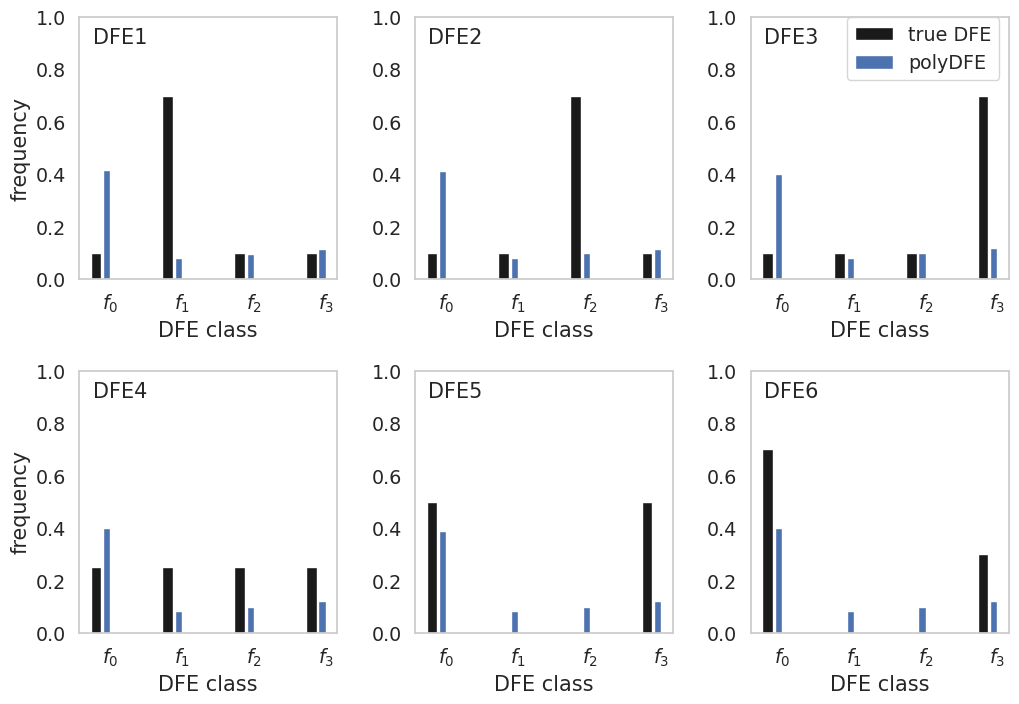

In [107]:
sns.set(rc={'figure.figsize':(12,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.25)
x = [a for a in range(0,4)]
for i in range(0, 6):
    ax = plt.subplot(2, 3, i+1)
    ax.bar([a-0.45 for a in x], DFE[i], width=0.15, color='k', align='center', label='true DFE')
    ax.bar([a-0.3 for a in x], infDFE[i+1], width=0.1, color='b', align='center', 
           label=r'polyDFE')
    plt.xticks([-0.25,0.75,1.75,2.75], [r'$f_0$', r'$f_1$', r'$f_2$', r'$f_3$'])
    plt.xlabel("DFE class")
    if(i==2):
        ax.legend(bbox_to_anchor=(1, 1.035))
    ax.set_ylim([0,1])   
    if((i==0) | (i==3)):
        ax.set_ylabel('frequency')
        
    ax.text(s='DFE' + str(i+1), x=-0.5, y=0.9)
    
plt.subplots_adjust(wspace=0.3, hspace=0.35)

plt.savefig('/home/vivak/rr_mu_demog_inference/plots/polyDFE.tiff', format='tiff', dpi=300, bbox_inches='tight')

In [101]:
df

,eps_an,theta_bar,a,g_mean,g_shape,S_max,g_scale
DFE,,,,,,,
1,0.069652,0.013465,1.086946,-16133.977403,0.077535,20.857890,-281306.906693
2,0.075745,0.012749,0.856948,-16887.713521,0.077994,24.403338,-274917.489293
3,0.078453,0.011049,0.789683,-16583.059144,0.080529,26.703819,-276384.843579
4,0.076068,0.012693,0.886276,-16545.681873,0.081365,22.209746,-248078.049762
5,0.076301,0.011921,2.262387,-16470.158345,0.084037,23.454411,-253633.935408
6,0.078407,0.012563,0.865624,-16941.778374,0.082298,21.579663,-239984.525205
